In [39]:
import sys
sys.path.append('./notebooks')
from gps_utils import rdp

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

# to suppress warnings of Seaborn's deprecated usage of Matplotlib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pykalman import KalmanFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<center>
<h1>Handling GPS data with Python</h1>
<img src="./gfx/gnome_maps.png" width=30%>
<h3>Dr. Florian Wilhelm</h3>
<h4>Senior Data Scientist @ <a href="http://www.inovex.de/">inovex</a></h4>
</center>

# Motivation

* Project work and general interest
* Hard to find information about Python libraries
* Interest in the mathematical algorithms of that domain
* Needed a subject for a EuroPython talk ;-)

# GPX: GPS Exchange Format

* common GPS data format
* based on XML schema
* describes waypoints, routes and tracks
* GPS coordinates based GS-84 ellipsoid, height in meters

<img src="./gfx/route_track_mod.png" widht=60%>

# General structure

```xml
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<gpx version="1.1" creator="Creator of the file">
  <metadata> <!-- metadata of the file --> </metadata>
  <wpt lat="xx.xxx" lon="yy.yyy"><!-- ... --></wpt>
  <!-- more waypoints -->
  <rte>
    <!-- attributes of the route -->
    <rtept lat="xx.xxx" lon="yy.yyy"><!-- ... --></rtept>
    <!-- more route points -->
  </rte>
  <!-- more routes -->
  <trk>
    <!-- attributes of the track -->
    <trkseg>
      <trkpt lat="xx.xxx" lon="yy.yyy"><!-- ... --></trkpt>
      <!-- more track points -->
    </trkseg>
    <!-- more track segments -->
  </trk>
  <!-- more tracks -->
</gpx>
```

# Example from Polar Flow
```xml
<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" version="1.1" creator="Polar Flow">
  <metadata>
    <author>
      <name>Polar</name>
    </author>
    <time>2016-04-17T08:02:12.000Z</time>
  </metadata>
  <trk>
    <trkseg>
      <trkpt lat="53.560591" lon="9.9755985">
        <ele>17.0</ele>
        <time>2016-04-17T08:02:12.000Z</time>
      </trkpt>
      <trkpt lat="53.560591" lon="9.9755985">
        <ele>17.0</ele>
        <time>2016-04-17T08:02:13.000Z</time>
      </trkpt>
      <!-- ... many more points -->
    </trkseg>
  </trk>
</gpx>
```

# gpxpy: GPX file parser

* for reading and writing GPX files
* licensed unter Apache 2.0
* contains `gpxinfo` cli tool for basic stats
* Python 3 compatible
* written by Tomo Krajina
* used by http://www.trackprofiler.com/

In [40]:
import gpxpy

with open('./gpx/hh_marathon.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

In [41]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([
        {'lat': p.latitude, 
         'lon': p.longitude, 
         'ele': p.elevation,
         'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head(3)

,ele,lat,lon
time,,,
2016-04-17 08:02:12,17.0,53.560591,9.975599
2016-04-17 08:02:13,17.0,53.560591,9.975599
2016-04-17 08:02:14,17.0,53.560561,9.975591


# Plotting a track

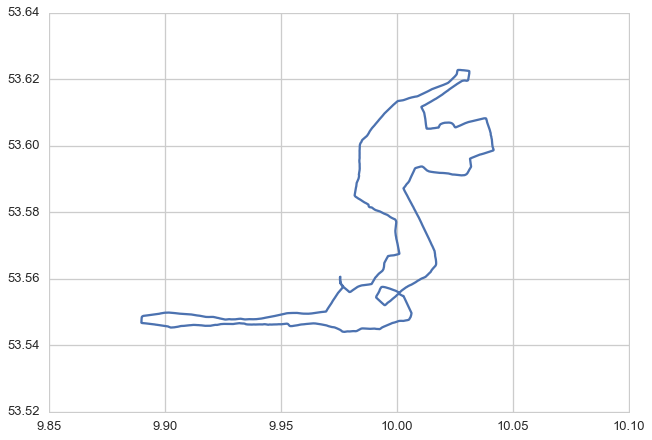

In [42]:
plt.plot(coords['lon'].values, coords['lat'].values);

## ... and the actual GPS coordinates

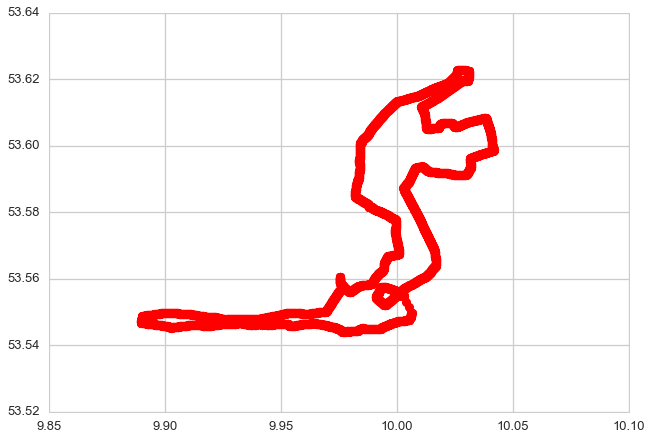

In [43]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values, coords['lat'].values, 'ro');

# Ohh! Need to reduce the number of points!

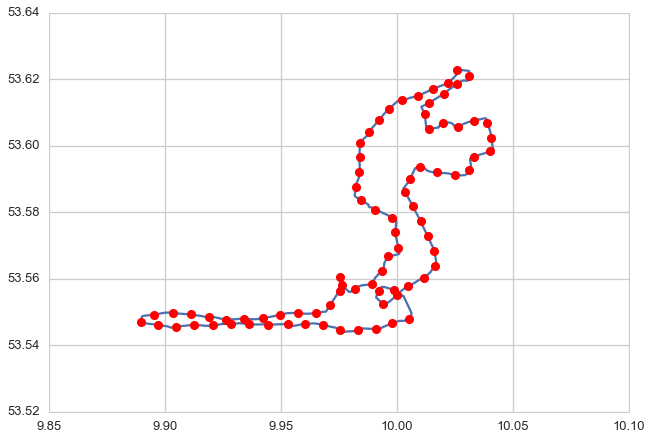

In [44]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values[::150], coords['lat'].values[::150], 'ro');

# Simplifying GPS tracks 

Most GPS sensors have a uniform sampling rate leading to overly many points on almost straight lines.

## How can we reduce the number of points?


<center>
    <h1>Ramer-Douglas-Peucker algorithm</h1>
    <br>
    <img id="example1" src="./gfx/rdp_animation_large.gif" rel:animated_src="./gfx/rdp_animation_large.gif" rel:auto_play="0" width="1024" height="1768" />
    <br>
    <script type="text/javascript">
        var sup1 = requirejs(["js/libgif"], function(SuperGif){
            var sup1 = new SuperGif({ gif: document.getElementById('example1') } );
            sup1.load(function(){
                document.getElementById('button_pause').onmousedown = function(event) {sup1.pause(); return false;};
                document.getElementById('button_play').onmousedown = function(event) {sup1.play(); return false;};
                document.getElementById('button_restart').onmousedown = function(event) {sup1.move_to(0); return false;};
                document.getElementById('button_end').onmousedown = function(event) {sup1.move_to(sup1.get_length()-1); return false;};
                document.getElementById('button_forward').onmousedown = function(event) {sup1.move_relative(1); return false;};
                document.getElementById('button_backword').onmousedown = function(event) {sup1.move_relative(-1); return false;};
            });
            
        
        })
    </script>
    <font size=3>
    <table>
      <tr>
       <td><a href="javascript:;" id="button_play"><i class="fa fa-play" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_pause"><i class="fa fa-pause" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_restart"><i class="fa fa-fast-backward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_backword"><i class="fa fa-step-backward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_forward"><i class="fa fa-step-forward" aria-hidden="true"></i></a></td>
       <td><a href="javascript:;" id="button_end"><i class="fa fa-fast-forward" aria-hidden="true"></i></a></td>
       </tr>
      </table>
     </font>
</center>

12072 points reduced to 193!


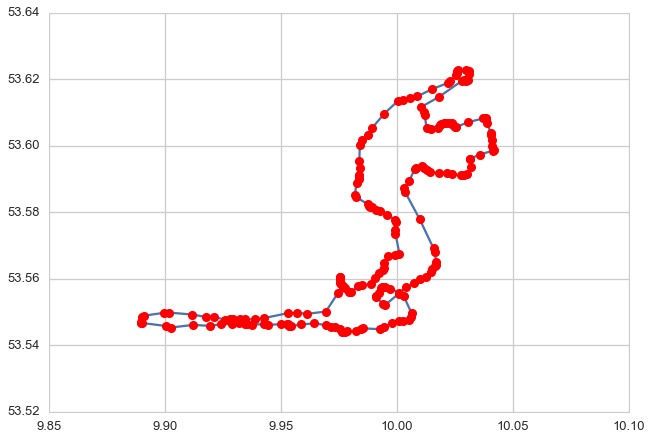

In [45]:
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon=1e-4)
print("{} points reduced to {}!".format(coords.shape[0], simple_coords.shape[0]))
plt.plot(simple_coords[:, 0], simple_coords[:, 1])
plt.plot(simple_coords[:, 0], simple_coords[:, 1], 'ro');

# Elevation of a GPS track

In [46]:
with open('./gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
    
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([{'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)

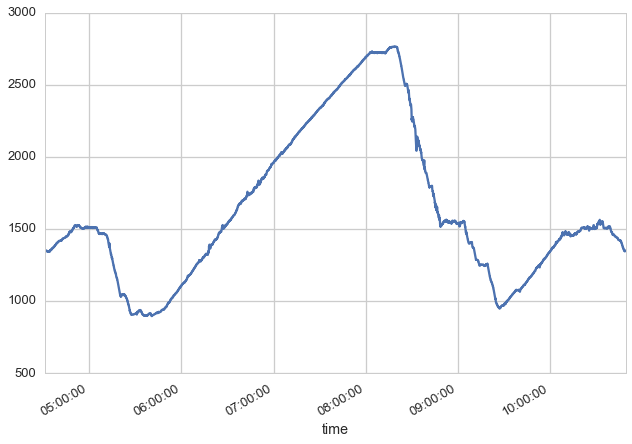

In [47]:
coords.ele.plot();

## ... but what if the elevation was missing?

In [48]:
# Delete elevation data
for p in gpx_file.tracks[0].segments[0].points:
    p.elevation = None

# srtm.py: add missing GPS elevation

* parser for the [Shuttle Radar Topography Mission elevation data](http://www2.jpl.nasa.gov/srtm/)
* extension for `gpxpy`
* licensed under Apache 2.0
* Python 3 compatible
* written by Tomo Krajina
* used by http://www.trackprofiler.com/

In [49]:
import srtm
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_file, smooth=True)

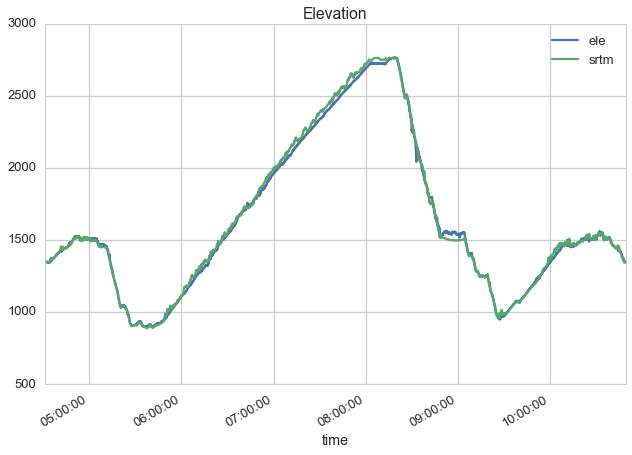

In [50]:
coords['srtm'] = [p.elevation for p in gpx_file.tracks[0].segments[0].points]
coords[['ele','srtm']].plot(title='Elevation');

# mplleaflet:  interactive Leaflet web maps

* converts a matplotlib plot into a pannable, zoomable slippy map
* extremely easy to use
* licensed under new-BSD
* integrates well with Jupyter
* Python 3 compatible
* tracks should be simplified with Ramer-Douglas-Peucker algorithm first

# First we start with a matplotlib plot...

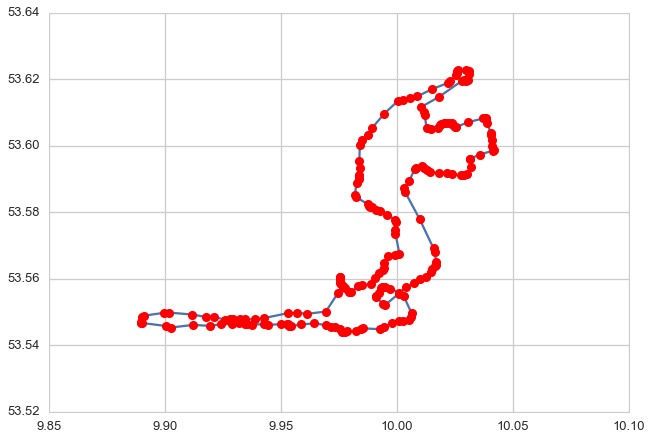

In [51]:
fig = plt.figure()
plt.plot(simple_coords[:,0], simple_coords[:,1])
plt.plot(simple_coords[:,0], simple_coords[:,1], 'ro');

# ... and project it onto OpenStreetMap

In [52]:
import mplleaflet
mplleaflet.display(fig=fig) # .show(fig=fig) to display in new window

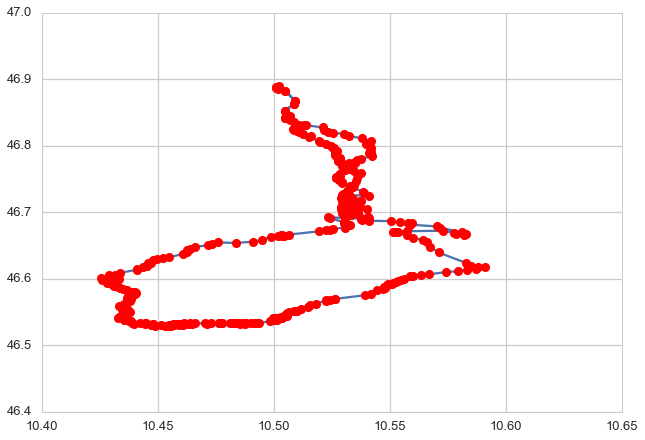

In [53]:
# prepare 3-laender-giro gps track
fig = plt.figure()
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon=0.0003)
plt.plot(simple_coords[:, 0], simple_coords[:, 1])
plt.plot(simple_coords[:, 0], simple_coords[:, 1], 'ro');

In [54]:
mplleaflet.display(fig=fig)

In [55]:
# we reload again since we changed the elevation
with open('./gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
segment = gpx_file.tracks[0].segments[0]

# Some curiosities...

In [56]:
gpx_file.get_uphill_downhill()

UphillDownhill(uphill=4446.100000000043, downhill=4439.100000000031)

### Didn't the organiser say something about roughly 2700hm?

# These bumps seem quite unrealistic

In [57]:
plt.rcParams['axes.xmargin'] = 0.0
plt.rcParams['axes.ymargin'] = 0.0

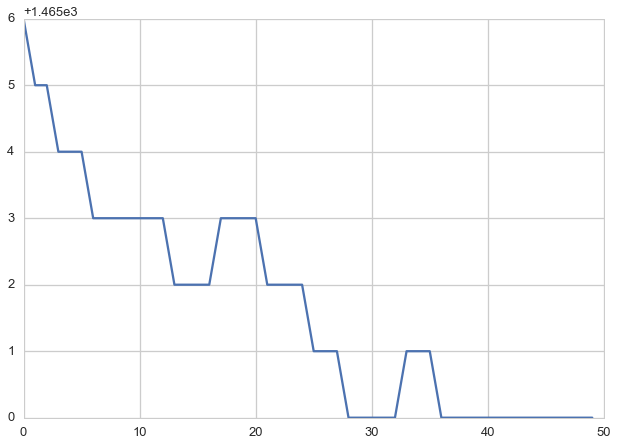

In [58]:
plt.plot(coords['ele'].values[2060:2110]);

# How about the speed?

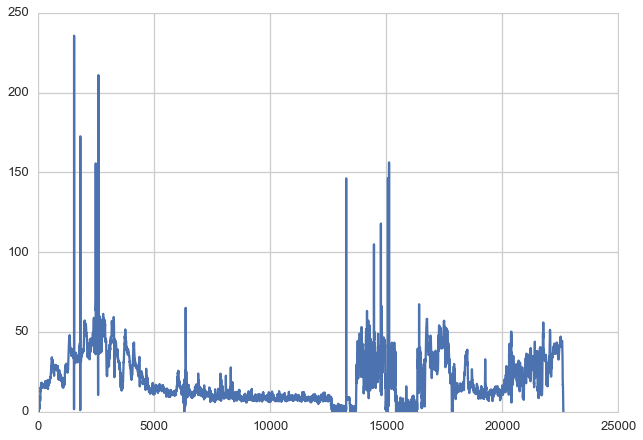

In [59]:
segment.points[0].speed, segment.points[-1].speed = 0., 0.
gpx_file.add_missing_speeds()
speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed);

# Kalman Filter and Smoother

* *State equation*: $\mathbf{x}_{k}=\mathbf{F}_{k}\mathbf {x}_{k-1}+\mathbf{B}_{k}\mathbf{u}_{k}+\mathbf{w}_{k}$ where 
  
  - $\mathbf{x}_{k}$ is the state vector at timestep $k$,
  - $\mathbf{u}_{k}$ is the control vector at timestep $k$,
  - $\mathbf{F}_{k}$ is the state transition matrix,
  - $\mathbf{B}_{k}$ is the control-input matrix,
  - $\mathbf{w}_{k}$ is the process noise $\mathbf{w}_{k}\sim{\mathcal{N}}(0,\mathbf{Q})$ with covariance $\mathbf{Q}$ 
  

* *Measurement equation*: $\mathbf{z}_{k}=\mathbf{H}_{k}\mathbf{x}_{k}+\mathbf{v}_{k}$ where

  - $\mathbf{z}_{k}$ is the measurement vector at timestep $k$,
  - $\mathbf{H}_{k}$ is the observation matrix,
  - $\mathbf{v}_{k}$ is the observation noise $\mathbf{v}_{k}\sim{\mathcal{N}}(0,\mathbf{R})$ with covariance $\mathbf{R}$ 

# Optimally average measurement and state estimation

Let
* $\mathbf{\hat{x}}_{k}^{-}$ be the *a priori*  state estimate with knowledge about the process prior to $k$
* $\mathbf{\hat{x}}_{k}$ be the *a posteriori* state estimate including the the measurement $z_{k}$

and an update equation linking $\mathbf{\hat{x}}_{k}$ to $\mathbf{\hat{x}}_{k}^{-}$, i.e.

$$\mathbf{\hat{x}}_{k} = \mathbf{\hat{x}}_{k}^{-} + \mathbf{K}(\mathbf{\mathbf{z}_{k} - \mathbf{H}\hat{x}}_{k}^{-})$$

where $\mathbf{K}$ is the *Kalman gain*.

**Goal:** Find an optimal $\mathbf{K}$ that minimizes the *a posteriori* estimate error covariance $\mathbf{P}_{k} = \mathbb{E}[\mathbf{e}_k,\mathbf{e}_k]$ with $\mathbf{e}_{k}\equiv\mathbf{x}_{k}-\mathbf{\hat{x}}_{k}$.


<small>[... read <a href="https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf">An Introduction to the Kalman Filter</a> by G. Welch & G. Bishop for more details]</small>

# Prediction-Correction Loop

<img src="./gfx/prediction_correction.png" width=80%>

# Kalman filter for GPS data

Given position $\mathbf{x}_{k}=(x_{k},y_{k},z_{k})$ and velocity $\mathbf{v}_{k}=(\alpha_{k},\beta_{k},\gamma_{k})$ our model state equation is
<big>$$\mathbf{x}_{k+1} = \mathbf{x}_{k} + \mathbf{v}_{k}dt + \mathbf{w}_{k}$$</big>
or in vector notation
$$
\begin{pmatrix}
x_{k+1} \\
y_{k+1} \\
z_{k+1} \\
\alpha_{k+1} \\
\beta_{k+1} \\
\gamma_{k+1} \\
\end{pmatrix}=
\begin{pmatrix}
1 & 0 & 0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
x_{k} \\
y_{k} \\
z_{k} \\
\alpha_{k} \\
\beta_{k} \\
\gamma_{k} \\
\end{pmatrix}+
\begin{pmatrix}
v^1_{k} \\
v^2_{k} \\
v^3_{k} \\
v^4_{k} \\
v^5_{k} \\
v^6_{k} \\
\end{pmatrix}
$$


# Since only the position is measured

Given measurment $\mathbf{z}_{k}=(\tilde{x}_k,\tilde{y}_k,\tilde{z}_k)$ our measurement equation is
<big> $$\mathbf{z}_{k}=\mathbf{H}_{k}\mathbf{x}_{k}+\mathbf{v}_{k}$$</big>
or in vector notation
$$
\begin{pmatrix}
\tilde{x}_k\\
\tilde{y}_k\\
\tilde{z}_k\\
\end{pmatrix}=
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
\end{pmatrix}\cdot
\begin{pmatrix}
x_{k} \\
y_{k} \\
z_{k} \\
\alpha_{k} \\
\beta_{k} \\
\gamma_{k} \\
\end{pmatrix}+
\begin{pmatrix}
v^1_{k} \\
v^2_{k} \\
v^3_{k} \\
v^4_{k} \\
v^5_{k} \\
v^6_{k} \\
\end{pmatrix}
$$
with an observation covariance matrix $\mathbf{R}=diag(1e-4,1e-4,100)$ where $1e-4$ is roughly 10-30m in longitude/latitude

# pykalman: Kalman filter, smoother and EM 

* dead-simple to use and quite powerful
* comes with examples and good documentation
* also allows non-affine state transitions (Unscented Kalman)
* licensed under new-bsd
* written by Daniel Duckworth

### But some data wrangling first

In [60]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'speed': p.speed,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.set_index('time', inplace=True)
coords.head(2)

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 04:31:27,1343.0,0,46.889062,10.502119,0.000000
2016-06-26 04:31:28,1343.0,1,46.889062,10.502119,0.018335


In [61]:
coords.tail(2)

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 10:49:04.117,1350.0,22630,46.888574,10.502013,0.079782
2016-06-26 10:49:05.117,1350.0,22631,46.888575,10.502012,0.000000


### Let's make sure we have 1sec intervals

In [62]:
coords.index = np.round(coords.index.astype(np.int64), -9).astype('datetime64[ns]')

### What about signal loss?

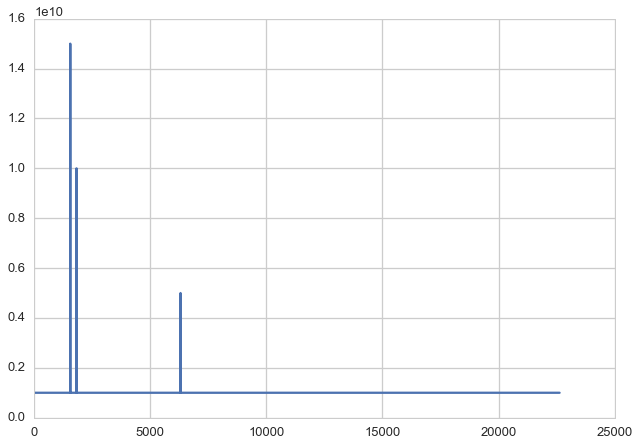

In [63]:
plt.plot(np.diff(coords.index));

### We fix signal loss by resampling

In [64]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,ele,idx,lat,lon,speed
2016-06-26 04:57:17,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:18,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:19,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:20,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:21,NaN,NaN,NaN,NaN,NaN


### Now convert to good old numpy array, mask NaNs and plot...

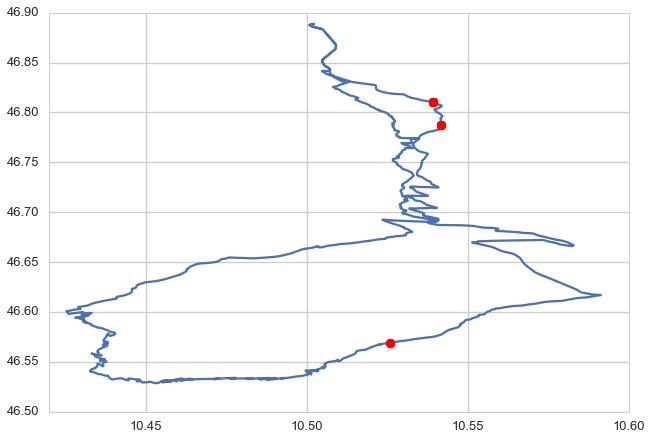

In [65]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)

plt.plot(measurements[:,0], measurements[:,1])
filled_coords = coords.fillna(method='pad').ix[coords.ele.isnull()]
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'ro');

### Setup the Kalmann filter & smoother

In [66]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-6, 1e-6, 1e-6])**2

kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

### ... and fit the transition covariance matrix

In [67]:
kf = kf.em(measurements, n_iter=1000) # takes a very long time

In [68]:
# normally we would need about 1000 iterations, so we take this instead
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
Q = 0.5*(Q + Q.T) # assure symmetry
kf.transition_covariance = Q

### Now we smooth our track

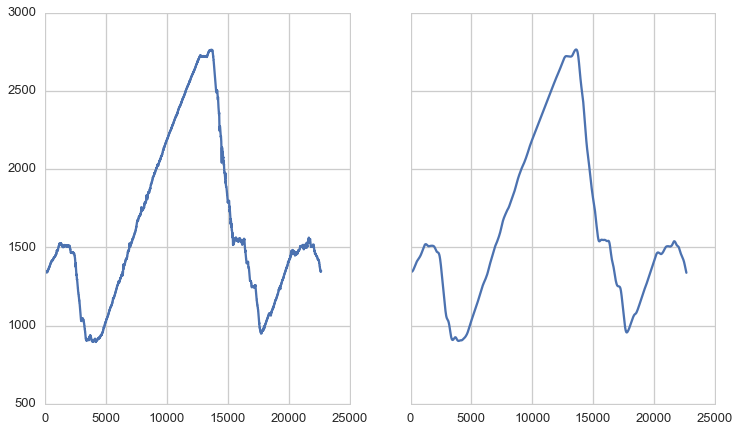

In [69]:
state_means, state_vars = kf.smooth(measurements)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 7))
ax1.plot(measurements[:,2]), ax2.plot(state_means[:,2]);

### After having wrote the smoothed data back...

In [70]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']
    
segment.get_uphill_downhill()

UphillDownhill(uphill=2677.5293611031921, downhill=2683.5375577693385)

### Sounds about right! 

### Smoothing the speed is a bit more involved but eventually

In [71]:
# Check the 4-pykalman notebook for the actual doing
with open('./gpx/3-laender-giro_cleaned.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
segment = gpx_file.tracks[0].segments[0]
segment.points[0].speed, segment.points[-1].speed = 0., 0.
gpx_file.add_missing_speeds()

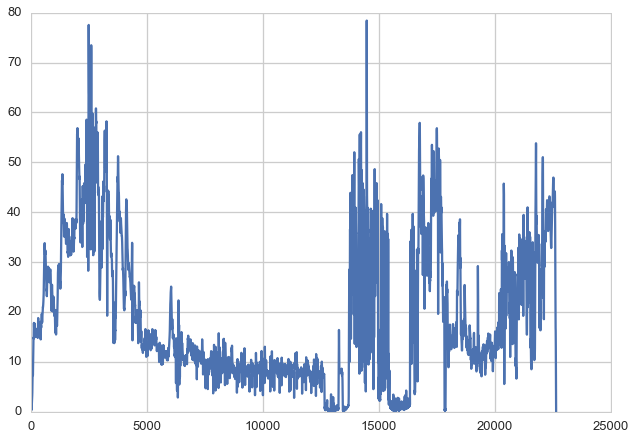

In [72]:
speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed);

## Summary of libraries

* **gpxpy** for reading, writing GPX files as well as imputing of missing values.
* **srtm.py** extends gpxpy to easily add missing elevation data to a GPX file.
* **mplleaflet** converts matplotlib plots into zoomable, pannable, [Leaflet](http://leafletjs.com/) map.
* **rdp** implements the Ramer-Douglas-Peucker algorithm (**currently only recursive**!).
* **pykalman** is a dead-simple Kalman filter, smoother and EM library.

More notebooks with examples can be found under: https://github.com/FlorianWilhelm/gps_data_with_python/tree/master/notebooks

<center><h1>Questions?</h1><br>
<img src=./gfx/light-bulb.jpg align="center" width=40%/></center>

# Credits

* RDP Example from [Marius Karthaus](http://karthaus.nl/rdp/)
* Waypoint/track graphic adapted from [Wikipedia](https://en.wikipedia.org/wiki/GPS_Exchange_Format)
* Logo on first slide from [Gnome Maps](https://wiki.gnome.org/Apps/Maps)
* Kalman prediction & correction graphic from [Bilgin's blog](http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies)
* Book [Kalman and Bayesian Filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) by Roger R. Labbe
